## Prevendo evasão de clientes

### 1. Introdução

A perda/desgaste de clientes, também conhecida como a porcentagem de clientes que param de usar os produtos ou serviços de uma empresa, é uma das métricas mais importantes para um negócio, pois geralmente custa mais adquirir novos clientes do que reter os existentes.

Ao usar a Análise de Sobrevivência, não apenas as empresas podem prever se os clientes provavelmente deixarão de fazer negócios, mas também **quando** esse evento poderá acontecer.
<p align="center">
<center><img alt="Churn" width="50%" src="https://cdn.pixabay.com/photo/2018/03/19/11/33/feedback-3239758_960_720.jpg"></center>
</p>


### 2 - Contexto

Uma empresa de software como serviço (SaaS) fornece um conjunto de produtos para pequenas e médias empresas, como armazenamento de dados, contabilidade, gerenciamento de viagens e despesas, bem como gerenciamento de folha de pagamento.

Para ajudar o CFO a prever os custos de aquisição e marketing para o próximo ano fiscal, a equipe de Data Science quer construir um modelo de rotatividade para prever quando os clientes provavelmente interromperão sua assinatura mensal. Assim, uma vez que os clientes tenham sido sinalizados como propensos a desistir dentro de uma determinada janela de tempo, a empresa pode tomar as ações de retenção necessárias.

### 3 - Conjunto de dados

#### 3.1 - Descrição e Visão Geral

O conjunto de dados contém as seguintes variáveis:

**product_data_storage:** Quantidade de armazenamento de dados em nuvem comprado em Gigabytes

**product_travel_expense:** Indica se o cliente está usando e pagando ativamente os serviços de gerenciamento de viagens e despesas ou não. ('Active', 'Free-Trial', 'No')

**product_payroll:** Indica se o cliente está usando e pagando ativamente os serviços de gerenciamento de folha de pagamento ou não. ('Active', 'Free-Trial', 'No')

**product_accounting:** Indica se o cliente está usando e pagando ativamente os serviços de Contabilidade ou não. ('Active', 'Free-Trial', 'No')

**csat_score:** O Customer Satisfaction Score (CSAT) é a medida de como os produtos e serviços fornecidos pela empresa atendem às expectativas dos clientes.

**articles_viewed:** Número de artigos que o cliente visualizou no site da empresa.

**smartphone_notifications_viewed:** Número de notificações de smartphone que o cliente visualizou.

**marketing_emails_clicked:** Número de e-mails de marketing que o cliente abriu.

**social_media_ads_viewed:** Número de anúncios de mídia social que o cliente visualizou.

**minutes_customer_support:** Minutos que o cliente gastou no telefone com o suporte ao cliente da empresa.

**company_size:** Tamanho da empresa.

**us_region:** Região dos EUA onde está localizada a sede do cliente.

**months_active:** Número de meses desde que o cliente iniciou sua assinatura.

**churned:** Especifica se o cliente parou de fazer negócios com a empresa.

In [69]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset

# Reading the dataset
raw_dataset = Dataset('churn').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head()

The raw_dataset has the following shape: (2000, 14).


,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,company_size,us_region,months_active,churned
0,2048,Free-Trial,Active,No,9,4,0,14,1,8.3,10-50,West North Central,3.0,1.0
1,2048,Free-Trial,Free-Trial,Active,9,4,2,12,1,0.0,100-250,South Atlantic,2.0,1.0
2,2048,Active,Active,Active,9,3,2,17,1,0.0,100-250,East South Central,7.0,0.0
3,500,Active,Free-Trial,No,10,0,0,14,0,0.0,50-100,East South Central,8.0,1.0
4,5120,Free-Trial,Active,Free-Trial,8,5,0,17,0,0.0,50-100,East North Central,7.0,0.0


In [70]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   product_data_storage             2000 non-null   int64  
 1   product_travel_expense           2000 non-null   object 
 2   product_payroll                  2000 non-null   object 
 3   product_accounting               2000 non-null   object 
 4   csat_score                       2000 non-null   int64  
 5   articles_viewed                  2000 non-null   int64  
 6   smartphone_notifications_viewed  2000 non-null   int64  
 7   marketing_emails_clicked         2000 non-null   int64  
 8   social_media_ads_viewed          2000 non-null   int64  
 9   minutes_customer_support         2000 non-null   float64
 10  company_size                     2000 non-null   object 
 11  us_region                        2000 non-null   object 
 12  months_active       

#### 3.2 - Variáveis categóricas

Existem váriaveis categóricas que precisam ser codificadas em vetores one-hot:

* product_travel_expense
* product_payroll
* product_accounting
* us_region
* company_size

In [71]:
# Creating one-hot vectors
categories = ['product_travel_expense', 'product_payroll', 'product_accounting',
              'us_region', 'company_size']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)

# Creating the time and event columns
time_column = 'months_active'
event_column = 'churned'

# Extracting the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

### 4 - Análise Exploratória de Dados

Faremos uma análise exploratória de dados mais detalhada aqui. Vamos verificar se o conjunto de dados contém valores nulos ou se possui linhas duplicadas, verificar as correlações entre as variáveis, etc.

#### 4.1 - Valores nulos e duplicados

A primeira coisa a fazer é verificar se o raw_dataset contém valores Null e tem linhas duplicadas.

In [72]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


O conjunto de dados não possui valores nulos ou duplicados.

#### 4.2 - Correlações

Vamos calcular e visualizar a correlação entre as variáveis

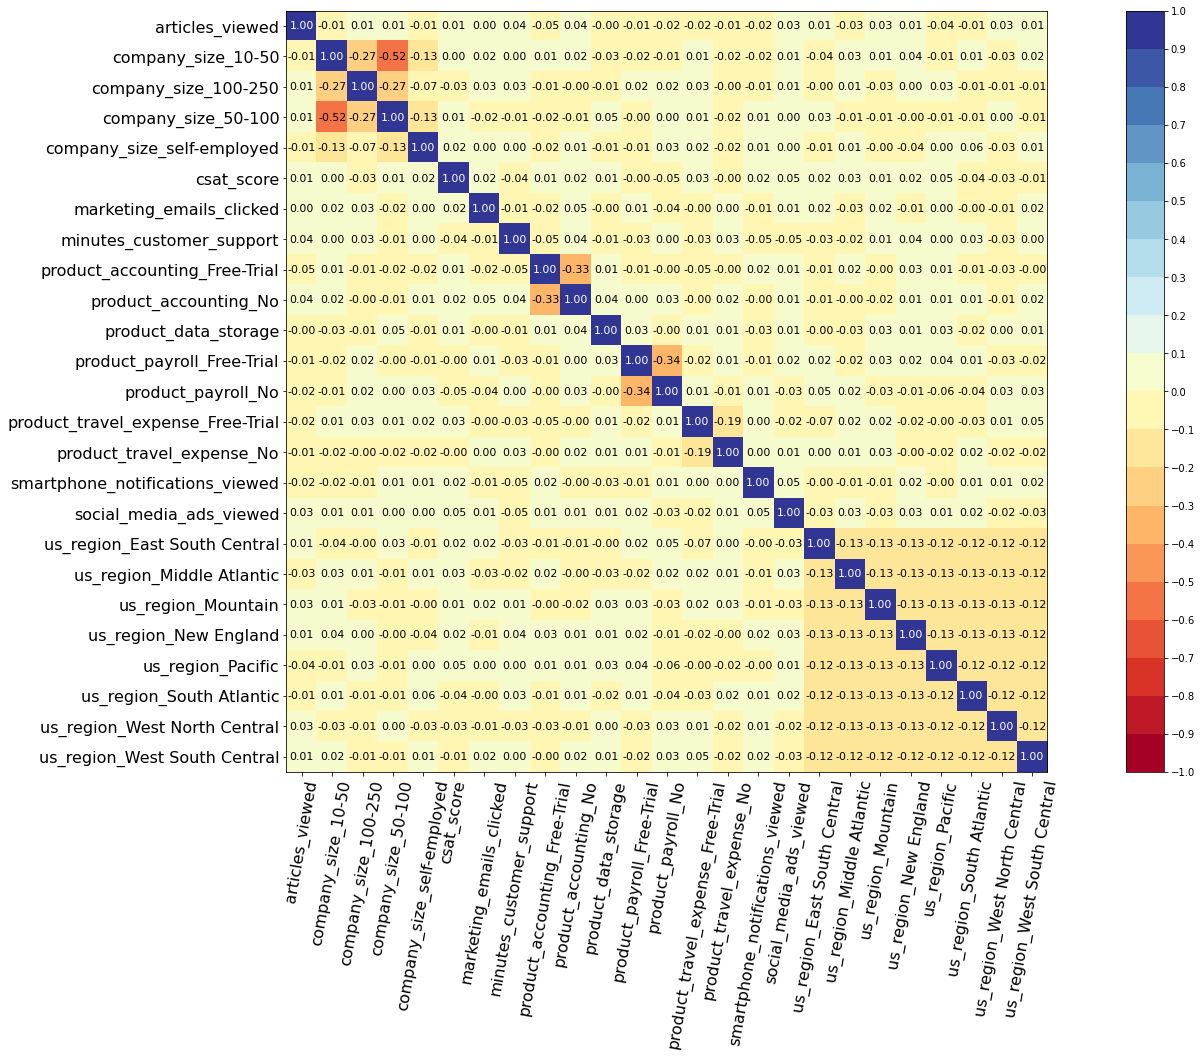

In [73]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(28,14), text_fontsize=11)

Como podemos ver, não há correlações alarmantes.

#### 4.3 - Visualização dos dados

Vamos conferir/visualizar as estatísticas das variáveis: 

##### 4.2.1 - Variáveis numéricas 

Vamos exibir o boxplot e o histograma de cada feature.

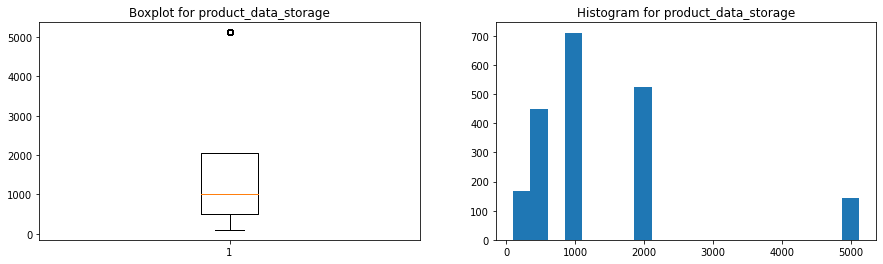

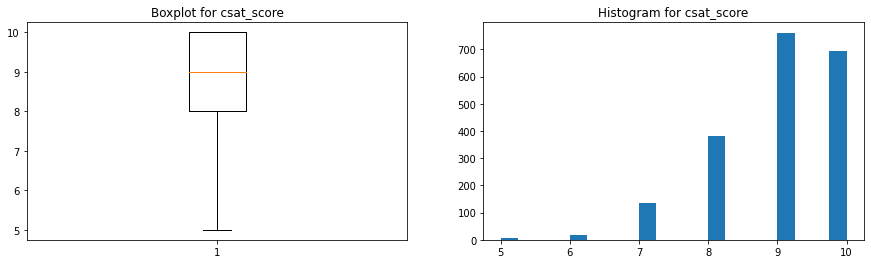

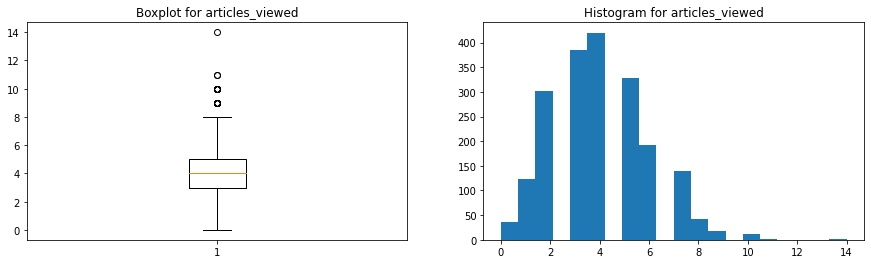

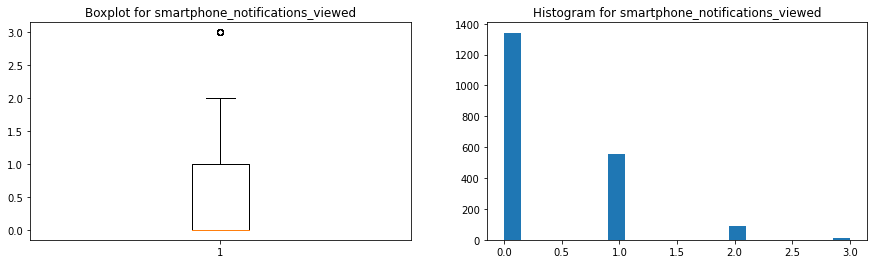

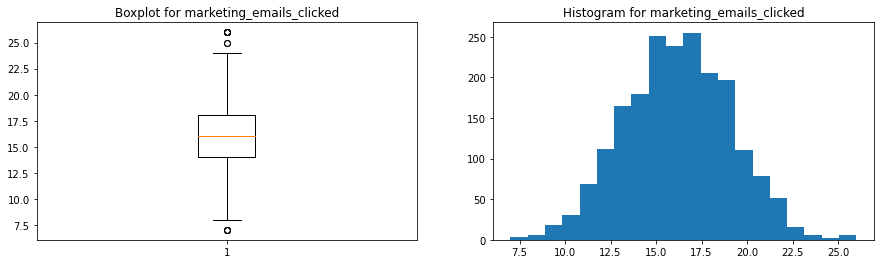

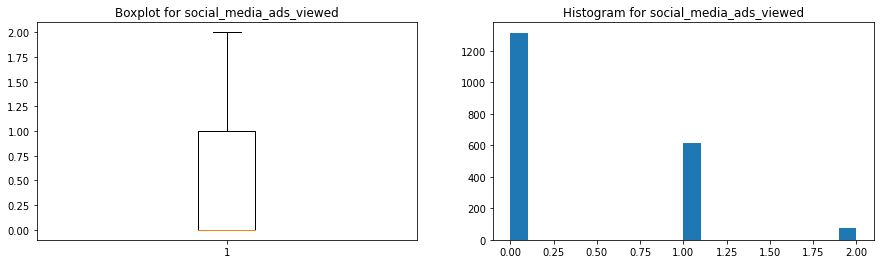

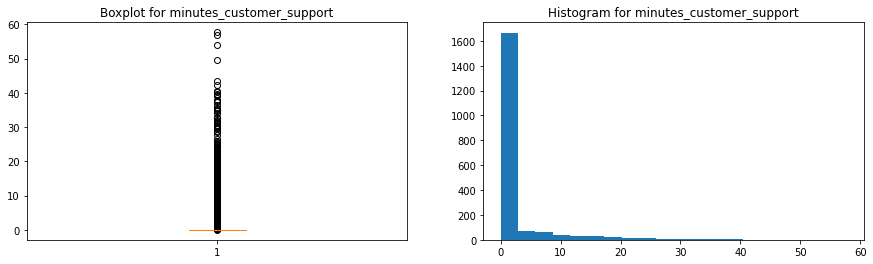

In [74]:
numerical = ['product_data_storage', 'csat_score', 'articles_viewed','smartphone_notifications_viewed',
 'marketing_emails_clicked','social_media_ads_viewed', 'minutes_customer_support']
for feature in numerical:

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title('Boxplot for {}'.format(feature))

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title('Histogram for {}'.format(feature))

    # Display
    plt.show()

Algumas features possuem muitos outliers, porém não iremos removê-los. Além disso, algumas variáveis não parecem ser uniformemente distribuídas.

##### 4.2.2 - Variáveis categóricas

Vamos exibir as ocorrências das categorias em um gráfico de barras para cada recurso

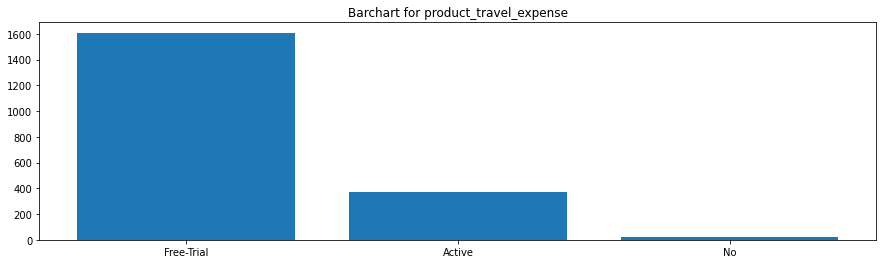

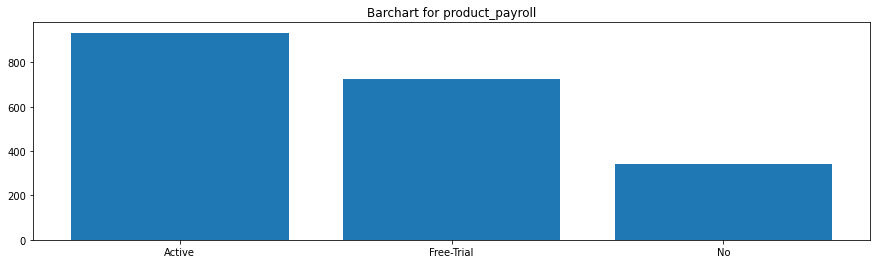

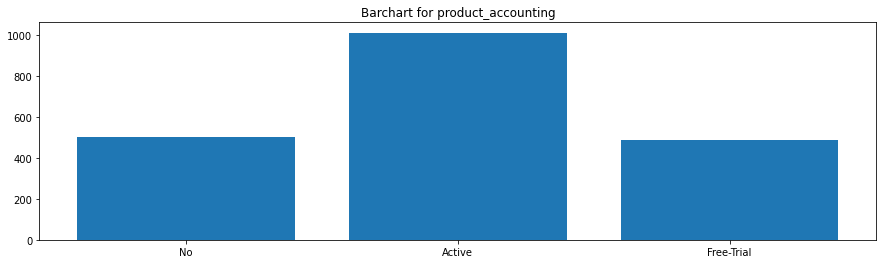

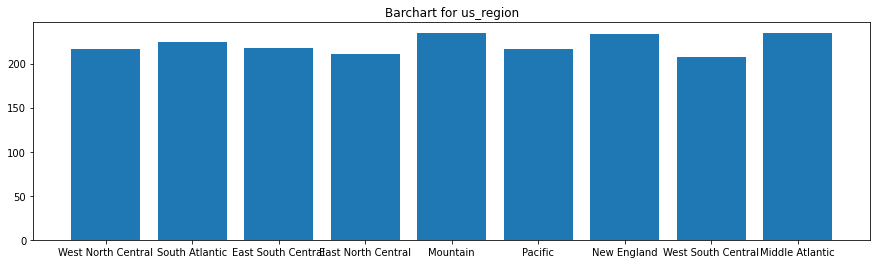

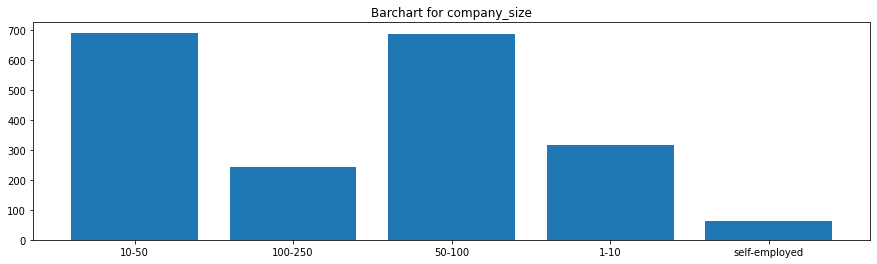

In [75]:
from collections import Counter
for feature in categories:

    # Creating an empty chart
    fig, ax = plt.subplots(figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Counting the number of occurrences for each category
    data = Counter(x)
    category = list(data.keys())
    counts = list(data.values())

    # Boxplot
    ax.bar(category, counts)

    # Display
    plt.title( 'Barchart for {}'.format(feature) )
    plt.show()

4.2.3 - Tempo & Evento

Mostraremos as ocorrências de evento e censura, bem como a distribuição da variável de saída para ambas as situações.

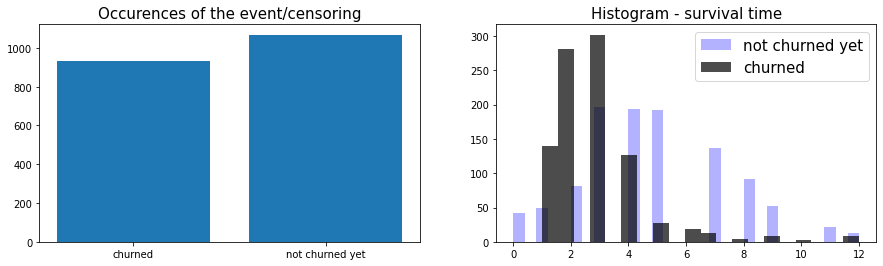

In [76]:
# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(raw_dataset['churned'].replace({0:'not churned yet', 1:'churned'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title( 'Occurences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = raw_dataset.loc[ raw_dataset['churned'] == 0, 'months_active']
ax2.hist(time_0, bins=30, alpha=0.3, color='blue', label = 'not churned yet')

# Showing the histogram of the survival times for the events
time_1 = raw_dataset.loc[ raw_dataset['churned'] == 1, 'months_active']
ax2.hist(time_1, bins=20, alpha=0.7, color='black', label = 'churned')
ax2.set_title( 'Histogram - survival time', fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

Aqui, podemos ver que a proporção entre dados censurados e não censurados é bastante balanceada e que a evasão de clientes começa a acontecer a partir da primeira semana.

### 5 - Modelagem

#### 5.1 - Construindo o modelo

Para realizar a validação cruzada posteriormente e avaliar o desempenho do modelo, vamos dividir o conjunto de dados em conjuntos de treinamento e teste.

In [77]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split(range(N), test_size=0.35, random_state = 42)
data_train = dataset.loc[index_train].reset_index(drop=True)
data_test  = dataset.loc[index_test].reset_index(drop=True)

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

Vamos agora ajustar um modelo de Conditional Survival Forest ao conjunto de treinamento.

In [78]:
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='sqrt',
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1)

ConditionalSurvivalForestModel

#### 5.2 - Importância das variáveis

Construir um modelo de Survival Forest nos permite calcular a importância dos recursos:

In [79]:
# Computing variables importance
csf.variable_importance_table.head(5)

,feature,importance,pct_importance
0,csat_score,14.544835,0.209485
1,product_payroll_No,11.095097,0.159799
2,minutes_customer_support,9.675053,0.139347
3,product_accounting_No,9.413314,0.135577
4,product_travel_expense_Free-Trial,7.029684,0.101246


Graças à importância dos recursos, entendemos melhor o que impulsiona a retenção ou o churn. Aqui, os produtos de Contabilidade e Gestão de Folha de Pagamento, a pontuação na pesquisa de satisfação e o tempo gasto no telefone com o suporte ao cliente têm um papel primordial.

### 6 - Validação Cruzada

Para avaliar o desempenho do modelo, dividimos anteriormente o conjunto de dados original em conjuntos de treinamento e teste, para que agora possamos calcular suas métricas de desempenho no conjunto de teste:

#### 6.1 - C-index

O índice C representa a avaliação global do poder de discriminação do modelo: esta é a capacidade do modelo de fornecer corretamente uma classificação confiável dos tempos de sobrevivência com base nas pontuações de risco individuais. Em geral, quando o índice C está próximo de 1, o modelo tem um poder discriminatório quase perfeito; mas se for próximo de 0,5, não tem capacidade de discriminar entre indivíduos de baixo e alto risco.

In [80]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.84


#### 6.2 - Brier Score

A pontuação de Brier mede as discrepâncias médias entre o status e as probabilidades estimadas em um determinado momento. Assim, quanto menor a pontuação (geralmente abaixo de 0,25), melhor o desempenho preditivo. Para avaliar a medida de erro geral em vários pontos de tempo, o Integrated Brier Score (IBS) geralmente também é calculado.

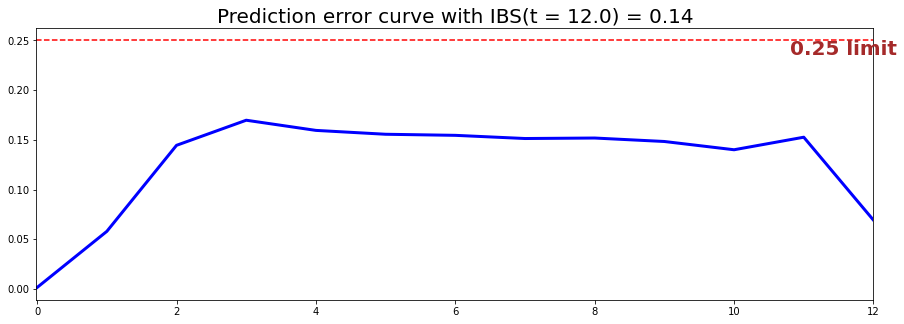

IBS: 0.14


In [81]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=12,
    figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

### 7 - Previsões
#### 7.1 - Previsões gerais

Agora que construímos um modelo que parece fornecer ótimos desempenhos, vamos comparar a série temporal do número real e previsto de clientes que deixam de fazer negócios com a empresa, para cada tempo $t$.

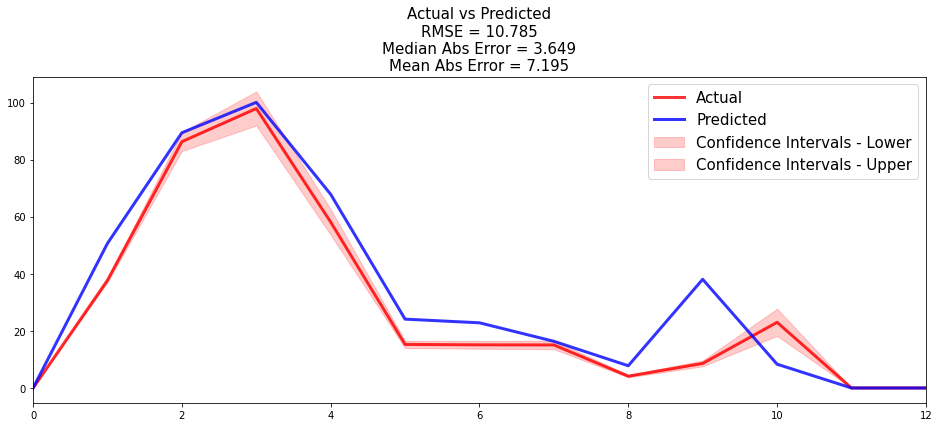

In [82]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk=False,  figure_size=(16, 6),
                            metrics=['rmse', 'mean', 'median'])

O modelo fornece resultados muito bons em geral, pois em uma janela inteira de 12 meses, ele apresenta apenas um erro médio absoluto de aproximadamente 7 clientes.

#### 7.2 - Previsões individuais

Agora que sabemos que podemos fornecer previsões confiáveis para um grupo inteiro, vamos calcular a **probabilidade de um cliente permanecer para todos os tempos $t$**.

Primeiro, podemos construir os grupos de risco com base na distribuição dos escores de risco. A função auxiliar `create_risk_groups`, que pode ser encontrada em `pysurvival.utils.display`, nos ajudará a fazer isso:

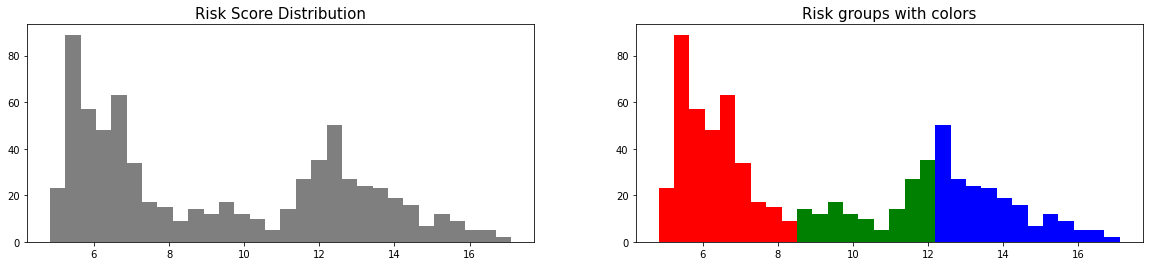

In [83]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=csf, X=X_test,
    use_log = False, num_bins=30, figure_size=(20, 4),
    low={'lower_bound':0, 'upper_bound':8.5, 'color':'red'},
    medium={'lower_bound':8.5, 'upper_bound':12.,'color':'green'},
    high={'lower_bound':12., 'upper_bound':25,  'color':'blue'}
    )

Aqui, é possível distinguir 3 grupos principais, grupos de baixo, médio e alto risco. Como o índice C é alto, o modelo será capaz de classificar adequadamente o tempo de sobrevivência de unidades aleatórias de cada grupo, de modo que $t_{high}≤t_{medium}≤t_{low}$

Vamos selecionar aleatoriamente uma unidade individual em cada grupo e comparar sua probabilidade de um cliente permanecer para todos os tempos $t$. Para demonstrar nosso ponto, selecionaremos propositadamente unidades que vivenciaram um evento para visualizar o tempo real do evento.

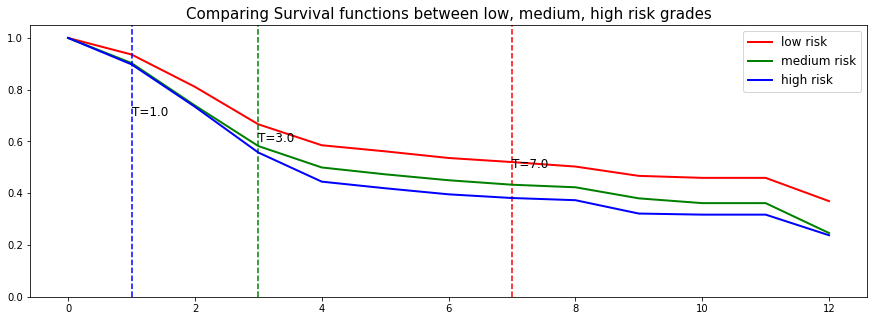

In [84]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Selecting a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = csf.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(csf.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

Aqui podemos ver que o modelo consegue fornecer uma ótima previsão do tempo do evento.

### 8 - Conclusão

Primeiro podemos salvar nosso modelo para colocá-lo em produção e pontuar futuros clientes.

In [85]:
# Let's now save our model
# from pysurvival.utils import save_model
# save_model(csf, '/Users/xxx/Desktop/churn_csf.zip')

Por fim, podemos ver que é possível prever quando os clientes deixarão de fazer negócios com a empresa em diferentes momentos. O modelo ajudará a empresa a ser mais proativa na hora de reter seus clientes; e fornecer uma melhor compreensão dos motivos que impulsionam o churn.